We'll write a simplifier a la Luckasz

In [1]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

class Solver:
    def __init__(self, n_qubits=3, qlr=0.01, qepochs=100,verbose=0, g=1, J=0):

        """"solver with n**2 possible actions: n(n-1) CNOTS + n 1-qubit unitary"""
        self.n_qubits = n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.lower_bound_Eg = -2*self.n_qubits
        
        self.qlr = qlr
        self.qepochs=qepochs
        self.verbose=verbose


        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        
        self.final_params = []
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        
        self.observable=self.ising_obs(g=g, J=J)
        self.resolver = {}
        self.new_resolver = {} #this temporarly stores initialized parameters of identity resolution
        self.lowest_energy_found = -.1
        self.best_circuit_found = []
        self.best_resolver_found = {}
        
        
    def ising_obs(self, g=1, J=0):
        # -  \Gamma/2 \sum_i Z_i - J/2 \sum_{i} X_i X_{i+1}    (S_i = \Sigma_i/2; ej S_z = Z/2, S_x = X/2)
        ### analytic solution https://sci-hub.tw/https://www.sciencedirect.com/science/article/abs/pii/0003491670902708?via%3Dihub
        observable = [-float(0.5*g)*cirq.Z.on(q) for q in self.qubits] 
        for q in range(len(self.qubits)):
            observable.append(-float(0.5*J)*cirq.X.on(self.qubits[q])*cirq.X.on(self.qubits[(q+1)%len(self.qubits)]))
        #### E_0 = -\Gamma/2 \sum_k \Lambda_k , with \Lambda_k = \sqrt{ 1 + \lambda^{2}  + 2 \lambda \cos(k)}; 
        ### k = -N/2, ... , 0 ,... N/2-1 if N even
        #### k = -(N-1)/2, ... 0 , ... (N-1)/2 if N odd
        if self.n_qubits%2 == 0:
            val = -self.n_qubits/2
        else:
            val = -(self.n_qubits-1)/2
        values_q = []
        for k in range(2*self.n_qubits):
            values_q.append(val)
            val += 1/2
        ###soething wrong here.
        self.ground_energy = -(0.5*g)*np.sum(np.sqrt([1+(J/(2*g))**2 - (np.cos(2*np.pi*q/self.n_qubits)*(J/g)) for q in values_q]))
        return observable
        
    def index_meaning(self,index):
        if index<self.number_of_cnots:
            print("cnot: ",self.indexed_cnots[str(index)])
            return
        else:
            print("1-qubit unitary on: ",(index-self.number_of_cnots)%self.n_qubits)
            return

    def append_to_circuit(self, ind, circuit, params, new_index=False):
        """
        appends to circuit the index of the gate;
        and if one_hot_gate implies a rotation,
        appends to params a symbol
        """
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            return circuit, params
        else:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(3),self.parametrized_unitary):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
            return circuit, params
        
    def give_circuit(self, lista,one_hot=False):
        circuit, symbols = [], []
        for k in lista:
            circuit, symbols = self.append_to_circuit(k,circuit,symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols
    
    
    def resolution_2cnots(self, q1, q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        return [cnot, u1, u2, cnot]
    
    def resolution_1qubit(self, q):
        u1 = self.number_of_cnots + q
        return [u1]
        

    def dressed_cnot(self,q1,q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        u3 = self.number_of_cnots + q1
        u4 = self.number_of_cnots + q2
        return [u1,u2,cnot,u3,u4]
    
    def dressed_ansatz(self, layers=1):
        c=[]
        for layer in range(layers):
            qubits = list(range(self.n_qubits))
            qdeph = qubits[layers:]
            for q in qubits[:layers]:
                qdeph.append(q)
            for ind1, ind2 in zip(qubits,qdeph):
                for k in self.dressed_cnot(ind1,ind2):
                    c.append(k)
        return c


    def prepare_circuit_insertion(self,gates_index, block_to_insert, index_insertion):
        """gates_index is a vector with integer entries, each one describing a gate
            block_to_insert is block of unitaries to insert at index insertion
        """
        circuit = cirq.Circuit()
        idx_circuit=[]
        symbols = []
        new_symbols = []
        new_resolver = {}

        if gates_index == []:
            indices = [-1]
        else:
            indices = gates_index
        for ind, g in enumerate(indices):
            #### insert new block ####
            if ind == insertion_index:
                for gate in block_to_insert:
                    idx_circuit.append(gate)
                    if gate < self.number_of_cnots:
                        control, target = self.indexed_cnots[str(gate)]
                        circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                    else:
                        qubit = self.qubits[(gate-self.number_of_cnots)%self.n_qubits]
                        for par, gateblack in zip(range(3),self.parametrized_unitary):
                            new_symbol = "New_th_"+str(len(new_symbols))
                            new_symbols.append(new_symbol)
                            new_resolver[new_symbol] = np.random.uniform(-.1,.1) #rotation around epsilon... we can do it better afterwards
                            circuit.append(gateblack(sympy.Symbol(new_symbol)).on(qubit))
            if 0<= g < self.number_of_cnots:
                idx_circuit.append(g)
                control, target = self.indexed_cnots[str(g)]
                circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            elif g>= self.number_of_cnots:
                
                idx_circuit.append(g)
                qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
                for par, gate in zip(range(3),self.parametrized_unitary):
                    new_symbol = "th_"+str(len(symbols))
                    symbols.append(new_symbol)
                    circuit.append(gate(sympy.Symbol(new_symbol)).on(qubit))
                    if not new_symbol in self.resolver.keys(): #this is in case it's the first time. Careful when deleting !
                        self.resolver[new_symbol] = np.random.uniform(-np.pi, np.pi)

        ### add identity for TFQ tocompute correctily expected value####
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))
        self.new_resolver = new_resolver
        variables = [symbols, new_symbols]
        return circuit, variables#, idx_circuit
    
    
    
    def TFQ_model(self, symbols, lr=None):
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
        output = tfq.layers.Expectation()(
                circuit_input,
                symbol_names=symbols,
                operators=tfq.convert_to_tensor([self.observable]),
                initializer=tf.keras.initializers.RandomNormal()) #we may change this!!!

        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        if lr is None:
            adam = tf.keras.optimizers.Adam(learning_rate=self.qlr)
        else:
            adam = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=adam, loss='mse')
        return model
    
    def initialize_model_insertion(self, variables):
        ### initialize model with parameters from previous model (describer by variables[0]) --> values in self.resolver
        ###(for the already-optimized ones), and close to identity for the block added, described by variables[1], whose values are in self.new_resolver

        symbols, new_symbols = variables
        circuit_symbols = []
        init_params = []
        for j in symbols:
            circuit_symbols.append(j)
            init_params.append(self.resolver[str(j)])#+ np.random.uniform(-.01,.01)) if you want to perturbate previous parameters..
        for k in new_symbols:
            circuit_symbols.append(k)
            init_params.append(self.new_resolver[str(k)])

        model = self.TFQ_model(circuit_symbols)
        model.trainable_variables[0].assign(tf.convert_to_tensor(init_params)) #initialize parameters of model (continuous parameters of uniraries)
        #with the corresponding values
        return model

    def run_circuit_from_index(self, gates_index, hyperparameters=None):
        """
        takes as input vector with actions described as integer
        and outputsthe energy of that circuit (w.r.t self.observable)
        
        hyperparameters = [epoch, lr]
        """
        ### create a vector with the gates on the corresponding qubit(s)
        circuit, symbols = self.give_circuit(gates_index)
        
        ### this is because each qubit should be "activated" in TFQ to do the optimization (if the observable has support on this qubit as well and you don't add I then error)
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))

        tfqcircuit = tfq.convert_to_tensor([circuit])
        if len(symbols) == 0:
            expval = tfq.layers.Expectation()(
                                            tfqcircuit,
                                            operators=tfq.convert_to_tensor([self.observable]))
            energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))
            final_params = []
            resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        else:
            if hyperparameters is None:
                model = self.TFQ_model(symbols)
                qoutput = tf.ones((1, 1))*self.lower_bound_Eg
                model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=self.verbose)
                energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
                final_params = model.trainable_variables[0].numpy()
                resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
            else:
                model = self.TFQ_model(symbols, hyperparameters[1])
                qoutput = tf.ones((1, 1))*self.lower_bound_Eg
                model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=hyperparameters[0], verbose=self.verbose)
                energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
                final_params = model.trainable_variables[0].numpy()
                resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        #self.current_circuit = gates_index
        self.resolver = resolver
        if self.accept_modification(energy):
            self.lowest_energy_found = energy
            self.best_circuit_found = gates_index
            self.best_resolver_found = resolver
        return gates_index, resolver, energy
    
    
    def accept_modification(self, energy):
        return np.abs(energy)/np.abs(self.lowest_energy_found) > .98
    
    
    def optimize_and_update(self, gates_index, model, circuit,variables,insertion_index_loaded):
    
        effective_qubits = list(circuit.all_qubits())
        q=0
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))
                q+=1
        if q == self.n_qubits:
            circuit.append(cirq.rz(sympy.Symbol("dummy")).on(self.qubits[0])) #hopefully you won't accept this, but in case you do, then it's better since it simplifies...
  

        tfqcircuit = tfq.convert_to_tensor([circuit])
        qoutput = tf.ones((1, 1))*self.lower_bound_Eg
        model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=0)
        energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
        
        if self.accept_modification(energy):

            #### if we accept the new configuration, then we update the resolver merging both symbols and new_symbols into self.resolver
            symbols, new_symbols = variables

            for ind,k in enumerate(symbols):
                self.resolver[k] = model.trainable_variables[0].numpy()[ind]

            for indnew,knew in enumerate(new_symbols):
                self.new_resolver[knew] = model.trainable_variables[0].numpy()[len(symbols)+indnew]

            final_symbols = []
            old_solver = []
            old_added = []

            final_resolver = {}
            new_circuit = []
            for ind, g in enumerate( gates_index):                 
                #### insert new block ####
                if ind == insertion_index_loaded:
                    for gate in block_to_insert:
                        new_circuit.append(gate)
                        if gate < sol.number_of_cnots:
                            pass
                        else:
                            for par, gateblock in zip(range(3),sol.parametrized_unitary):

                                var1 = "New_th_"+str(len(old_added))
                                old_added.append(var1)

                                var2 = "th_"+str(len(final_symbols))
                                final_symbols.append(var2)
                                final_resolver[var2] = self.new_resolver[var1] #

                if g < self.number_of_cnots:
                    new_circuit.append(g)
                    pass
                else:
                    new_circuit.append(g)
                    for par, gate in zip(range(3),self.parametrized_unitary):
                        var3 = "th_"+str(len(old_solver))
                        old_solver.append(var3)

                        var4 = "th_"+str(len(final_symbols))
                        final_symbols.append(var4)
                        final_resolver[var4] = self.resolver[var3] 

            self.resolver = final_resolver
            #self.current_circuit = new_circuit #### now the current circuit is the better one! otherwise you keep the previous (from self.run_circuit_from_index)
            self.best_circuit_found = new_circuit
            self.lowest_energy_found = energy
            self.best_resolver_found = resolver
            return new_circuit, self.resolver, energy, True
        else:
            return gates_index, self.resolver, self.lowest_energy_found, False
    
    def kill_one_unitary(self, gates_index, resolver, energy):
        """
        this function takes circuit as described by gates_index (sequence of integers)
        and returns when possible, a circuit, resolver, energy with one single-qubit unitary less.
        """

        circuit_proposals=[] #storing all good candidates.
        circuit_proposals_energies=[]
        for j in gates_index:
            indexed_prop=[]

            prop=cirq.Circuit()
            checking = False
            ko=0
            to_pop=[]

            for k in gates_index:
                if k < self.number_of_cnots:
                    indexed_prop.append(k)
                    control, target = self.indexed_cnots[str(k)]
                    prop.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                else:
                    if k != j:
                        indexed_prop.append(k)
                        qubit = self.qubits[(k-self.number_of_cnots)%self.n_qubits]
                        for par, gate in zip(range(3),self.parametrized_unitary):
                            new_param = "th_"+str(ko)
                            ko+=1
                            prop.append(gate(sympy.Symbol(new_param)).on(qubit))
                    else:
                        checking=True
                        for i in range(3):
                            to_pop.append("th_"+str(ko))
                            ko+=1
            if checking is True:
                nr = resolver.copy()
                for p in to_pop:
                    nr.pop(p)  
                
                effective_qubits = list(prop.all_qubits())
                for k in self.qubits:
                    if k not in effective_qubits:
                        prop.append(cirq.I.on(k))
                
                tfqcircuit = tfq.convert_to_tensor([cirq.resolve_parameters(prop, nr)]) ###resolver parameters !!!
                expval = tfq.layers.Expectation()(
                                        tfqcircuit,
                                        operators=tfq.convert_to_tensor([self.observable]))
                new_energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))

                if self.accept_modification(new_energy):
                    ordered_resolver = {}
                    for ind,k in enumerate(nr.values()):
                        ordered_resolver["th_"+str(ind)] = k
                    circuit_proposals.append([indexed_prop,ordered_resolver,new_energy])
                    circuit_proposals_energies.append(new_energy)
        if len(circuit_proposals)>0:
            favourite = np.random.choice(len(circuit_proposals))
            short_circuit, resolver, energy = circuit_proposals[favourite]
            #self.current_circuit = short_circuit
            self.resolver = resolver
            self.best_resolver_found = resolver
            self.best_circuit_found = short_circuit
            self.lowest_energy_found = circuit_proposals_energies[favourite]

            simplified=True
            return short_circuit, resolver, energy, simplified
        else:
            simplified=False
            return gates_index, resolver, energy, simplified

    
    def simplify_circuit(self,indexed_circuit):
        """this function kills repeated unitaries and 
        CNOTS and returns a simplified indexed_circuit vector"""
        #load circuit on each qubit
        connections={str(q):[] for q in range(self.n_qubits)} #this saves the gates in each qubit
        places_gates = {str(q):[] for q in range(self.n_qubits)} #this saves, for each gate on each qubit, the position in the original indexed_circuit


        flagged = [False]*len(indexed_circuit) #to check if you have seen a cnot already, so not to append it twice to the qubit's dictionary

        for q in range(self.n_qubits): #sweep over all qubits
            for nn,idq in enumerate(indexed_circuit): #sweep over all gates in original circuit's vector
                if idq<self.number_of_cnots: #if the gate it's a CNOT or not
                    control, target = self.indexed_cnots[str(idq)] #give control and target qubit
                    if q in [control, target] and not flagged[nn]: #if the qubit we are looking at is affected by this CNOT, and we haven't add this CNOT to the dictionary yet
                        connections[str(control)].append(idq)
                        connections[str(target)].append(idq)
                        places_gates[str(control)].append(nn)
                        places_gates[str(target)].append(nn)
                        flagged[nn] = True #so you don't add the other
                else:
                    if idq%self.n_qubits == q: #check if the unitary is applied to the qubit we are looking at
                        connections[str(q)].append("u")
                        places_gates[str(q)].append(nn)


        ### now reducing the circuit
        new_indexed_circuit = indexed_circuit.copy()
        for q, path in connections.items(): ###sweep over qubits: path is all the gates that act this qubit during the circuit
            for ind,gate in enumerate(path):
                if gate == "u": ## IF GATE IS SINGLE QUIT UNITARY, CHECK IF THE NEXT ONES ARE ALSO UNITARIES AND KILL 'EM
                    for k in range(len(path)-ind-1):
                        if path[ind+k+1]=="u":
                            new_indexed_circuit[places_gates[str(q)][ind+k+1]] = -1
                        else:
                            break
                elif gate in range(self.number_of_cnots) and ind<len(path)-1: ### self.number_of_cnots is the maximum index of a CNOT gate for a fixed self.n_qubits.
                    if path[ind+1]==gate and not (new_indexed_circuit[places_gates[str(q)][ind]] == -1): #check if the next gate is the same CNOT; and check if I haven't corrected the original one (otherwise you may simplify 3 CNOTs to id)
                        others = self.indexed_cnots[str(gate)].copy()
                        others.remove(int(q)) #the other qubit affected by the CNOT
                        for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                            if jgate == gate and connections[str(others[0])][jind+1] == gate: ##i find the same gate that is repeated in both the original qubit and this one
                                if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]) and (places_gates[str(q)][ind+1] == places_gates[str(others[0])][jind+1]): #check that positions in the indexed_circuit are the same
                                 ###maybe I changed before, so I have repeated in the original but one was shut down..
                                    new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                    new_indexed_circuit[places_gates[str(q)][ind+1]] = -1 ###just kill the repeated CNOTS
                                    break
                                    
                if gate in range(self.number_of_cnots) and ind == 0: ###if I have a CNOT just before initializing, it does nothing (if |0> initialization).
                    others = self.indexed_cnots[str(gate)].copy()
                    others.remove(int(q)) #the other qubit affected by the CNOT
                    for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                        if jgate == gate and jind==0: ##it's also the first gate in the other qubit
                            if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]): #check that positions in the indexed_circuit are the same
                                new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                break
                    
        #### remove the marked indices ###### 
        #### remove the marked indices ######            
        
        final=[]
        for gmarked in new_indexed_circuit:
            if not gmarked == -1:
                final.append(gmarked)
        return final
    
    def count_number_cnots(self, gates_index):
        c=0
        for k in gates_index:
            if k<self.number_of_cnots:
                c+=1
        return c

In [2]:
sols = {}
for j in tqdm(np.arange(.01,4.1,.4)):

    sol = Solver(n_qubits= 4, qlr=0.01, qepochs=200, g=1, J=j)
    history_energies=[]
    best_energies_found = []

    gates_index = [sol.number_of_cnots] ## begin with a certain circuit
    gates_index, resolver, energy= sol.run_circuit_from_index(gates_index)
#    sol.current_circuit = gates_index

    for kk in tqdm(range(25)):
        enns = [energy]
        which_block = np.random.choice([0,1], p=[.5,.5])
        if which_block == 0:
            qubit = np.random.choice(sol.n_qubits)
            block_to_insert = sol.resolution_1qubit(qubit)
            insertion_index = np.random.choice(max(1,len(gates_index))) #gives index between \in [0, len(gates_index) )
            
        else:
            qubits = np.random.choice(sol.n_qubits, 2,replace = False)
            block_to_insert = sol.resolution_2cnots(qubits[0], qubits[1])
            insertion_index = np.random.choice(max(1,len(gates_index))) #gives index between \in [0, len(gates_index) )
        
        #print(block_to_insert)
        ### optimize the circuit with the block appended. This is tricky since we initialize
        ###  the continuous parameters with the older ones, and the "block ones" close to identity
        circuit, variables = sol.prepare_circuit_insertion(gates_index, block_to_insert, insertion_index) #this either accepts or reject the insertion
        model = sol.initialize_model_insertion(variables) ### initialize the model in the previously optimized parameters & resolution to identity for the block

        gates_index, resolver, energy, accepted = sol.optimize_and_update(gates_index,model, circuit, variables, insertion_index) #inside, if better circuit is found, saves it.
        if accepted:
            #### try to kill one qubit unitaries ###
            for k in range(10):
                if len(gates_index)-sol.count_number_cnots(gates_index) > 2:
                    gates_index, resolver, energy, simplified =  sol.kill_one_unitary(gates_index, resolver, energy)

            ### simplify the circuit and if the length is changed I run the optimization again
            simplified_gates_index = sol.simplify_circuit(gates_index)
            if len(simplified_gates_index)<len(gates_index) and len(simplified_gates_index)>0:
                ggates_index, rresolver, eenergy = sol.run_circuit_from_index(simplified_gates_index,hyperparameters=[200,0.01]) #here I don't save the resolver since it's a mess
                if energy < sol.lowest_energy_found:
                    sol.lowest_energy_found = energy
                    sol.best_circuit_found = gates_index
                    sol.best_resolver_found = resolver
                    gates_index = ggates_index
                    resolver = resolver
                    energy = eenergy
        
        sol.new_resolver = {}
        history_energies.append(sol.lowest_energy_found)
        enns=[]
        #print("energy: ", energy, "... j", j)
    sol.history_energies=history_energies
    sols[str(j)] = sol
    print(history_energies)

  9%|▉         | 1/11 [01:00<10:00, 60.09s/it]

[array(-1.9999998, dtype=float32), -2.0, -1.9997454, array(-1.9999996, dtype=float32), array(-1.9999998, dtype=float32), array(-1.9999994, dtype=float32), array(-1.9999998, dtype=float32), array(-2., dtype=float32), -2.0000007, -2.0, array(-2., dtype=float32), -1.9999998, -1.9999996, -1.9999996, -1.9999996, array(-1.9999998, dtype=float32), array(-1.9999998, dtype=float32), array(-1.9999998, dtype=float32), array(-2.0000005, dtype=float32), -2.0, array(-2., dtype=float32), -1.9999996, array(-2.000001, dtype=float32), array(-2.0000014, dtype=float32), array(-2.0000117, dtype=float32)]



 18%|█▊        | 2/11 [02:07<09:19, 62.20s/it]

[array(-2.0207412, dtype=float32), array(-2., dtype=float32), array(-1.9999995, dtype=float32), array(-1.9999999, dtype=float32), array(-2., dtype=float32), array(-2., dtype=float32), array(-2., dtype=float32), -2.0000002, array(-1.9999994, dtype=float32), array(-2., dtype=float32), array(-1.9999989, dtype=float32), array(-2., dtype=float32), array(-1.9999998, dtype=float32), array(-1.9999996, dtype=float32), array(-2.0207257, dtype=float32), array(-2.020735, dtype=float32), -1.9999996, array(-1.9999998, dtype=float32), array(-2.020731, dtype=float32), -2.0, array(-2., dtype=float32), array(-2.0207286, dtype=float32), array(-2.0216017, dtype=float32), array(-2.0207322, dtype=float32), array(-2.0416813, dtype=float32)]



 27%|██▋       | 3/11 [03:58<10:16, 77.05s/it]

[array(-1.999999, dtype=float32), -1.9999998, array(-1.9999995, dtype=float32), -1.9999999, array(-1.9999995, dtype=float32), array(-1.9999995, dtype=float32), array(-2., dtype=float32), -2.0788045, -2.0788045, array(-2.1410673, dtype=float32), array(-2.1410673, dtype=float32), array(-2.1410673, dtype=float32), array(-2.1410673, dtype=float32), array(-2.1417422, dtype=float32), array(-2.1460462, dtype=float32), array(-2.1604543, dtype=float32), array(-2.160453, dtype=float32), array(-2.2744713, dtype=float32), array(-2.2744713, dtype=float32), array(-2.2744713, dtype=float32), array(-2.2744713, dtype=float32), array(-2.2744713, dtype=float32), array(-2.2746217, dtype=float32), array(-2.2667203, dtype=float32), array(-2.2667203, dtype=float32)]



 36%|███▋      | 4/11 [22:27<45:04, 386.37s/it]

[array(-1.9999992, dtype=float32), array(-2.1687498, dtype=float32), array(-2.3374925, dtype=float32), array(-2.8291705, dtype=float32), array(-2.8291705, dtype=float32), array(-2.8291705, dtype=float32), array(-2.8291705, dtype=float32), array(-2.8291705, dtype=float32), array(-2.8291705, dtype=float32), array(-2.8249419, dtype=float32), array(-2.8337653, dtype=float32), array(-2.8366728, dtype=float32), array(-2.8366823, dtype=float32), array(-2.8367147, dtype=float32), array(-2.8366718, dtype=float32), array(-2.836667, dtype=float32), array(-2.8379745, dtype=float32), array(-2.836769, dtype=float32), array(-2.8386722, dtype=float32), array(-2.8408122, dtype=float32), array(-2.8408642, dtype=float32), array(-2.8458195, dtype=float32), array(-2.842116, dtype=float32), array(-2.8401203, dtype=float32), array(-2.8411038, dtype=float32)]



 45%|████▌     | 5/11 [33:51<47:35, 475.94s/it]

[array(-2., dtype=float32), array(-2.2837272, dtype=float32), array(-3.5296779, dtype=float32), array(-3.5312128, dtype=float32), array(-3.530694, dtype=float32), array(-3.5266914, dtype=float32), array(-3.5266914, dtype=float32), array(-3.5266914, dtype=float32), array(-3.5266914, dtype=float32), array(-3.5266914, dtype=float32), array(-3.4837213, dtype=float32), array(-3.4837213, dtype=float32), array(-3.4828823, dtype=float32), array(-3.4831805, dtype=float32), array(-3.4831214, dtype=float32), array(-3.4833877, dtype=float32), array(-3.483405, dtype=float32), array(-3.530756, dtype=float32), array(-3.4835112, dtype=float32), array(-3.4832597, dtype=float32), array(-3.4948196, dtype=float32), array(-3.483294, dtype=float32), array(-3.5351384, dtype=float32), array(-3.5251682, dtype=float32), array(-3.5594263, dtype=float32)]



 55%|█████▍    | 6/11 [47:57<48:54, 586.90s/it]

[array(-2.4174116, dtype=float32), array(-2.7755592, dtype=float32), array(-2.8244262, dtype=float32), array(-4.207184, dtype=float32), array(-4.2070146, dtype=float32), array(-4.2070146, dtype=float32), array(-4.197068, dtype=float32), array(-4.2392797, dtype=float32), array(-4.2392797, dtype=float32), array(-4.2080436, dtype=float32), array(-4.1560764, dtype=float32), array(-4.2513084, dtype=float32), array(-4.244918, dtype=float32), array(-4.280037, dtype=float32), array(-4.253577, dtype=float32), array(-4.257187, dtype=float32), array(-4.205923, dtype=float32), array(-4.2558823, dtype=float32), array(-4.2753835, dtype=float32), array(-4.2798433, dtype=float32), array(-4.282976, dtype=float32), array(-4.281659, dtype=float32), array(-4.2811584, dtype=float32), array(-4.2794867, dtype=float32), array(-4.2787595, dtype=float32)]



 64%|██████▎   | 7/11 [57:40<39:03, 585.78s/it]

[array(-2.5648005, dtype=float32), -2.564786, array(-2.5647388, dtype=float32), array(-2.9750082, dtype=float32), array(-2.9751759, dtype=float32), array(-2.9751759, dtype=float32), array(-4.9733706, dtype=float32), array(-4.9734583, dtype=float32), array(-4.973584, dtype=float32), array(-4.971005, dtype=float32), array(-4.949333, dtype=float32), array(-4.972561, dtype=float32), array(-4.972561, dtype=float32), array(-4.972561, dtype=float32), array(-4.9740047, dtype=float32), array(-4.9735355, dtype=float32), array(-4.923726, dtype=float32), array(-5.0003004, dtype=float32), array(-4.973549, dtype=float32), array(-4.9733095, dtype=float32), array(-4.974034, dtype=float32), array(-4.973658, dtype=float32), array(-4.9998293, dtype=float32), array(-4.990281, dtype=float32), array(-4.981865, dtype=float32)]



 73%|███████▎  | 8/11 [1:00:52<23:22, 467.65s/it]

[-2.7222345, array(-2.722153, dtype=float32), array(-5.706862, dtype=float32), array(-5.707387, dtype=float32), array(-5.707387, dtype=float32), array(-5.707387, dtype=float32), array(-5.707387, dtype=float32), array(-5.707387, dtype=float32), array(-5.707387, dtype=float32), array(-5.771923, dtype=float32), array(-5.771923, dtype=float32), array(-5.7927284, dtype=float32), array(-5.7927284, dtype=float32), array(-5.7927284, dtype=float32), array(-5.7927284, dtype=float32), array(-5.7927284, dtype=float32), array(-5.789199, dtype=float32), array(-5.7856054, dtype=float32), array(-5.792514, dtype=float32), array(-5.789725, dtype=float32), array(-5.7910776, dtype=float32), array(-5.7922716, dtype=float32), array(-5.792429, dtype=float32), array(-5.787817, dtype=float32), array(-5.791708, dtype=float32)]



 82%|████████▏ | 9/11 [1:08:19<15:22, 461.34s/it]

[array(-1.9999994, dtype=float32), array(-2.7554326, dtype=float32), array(-6.5675745, dtype=float32), array(-6.5675745, dtype=float32), array(-6.5675745, dtype=float32), array(-6.5675745, dtype=float32), array(-6.5675745, dtype=float32), array(-6.5675745, dtype=float32), array(-6.5666246, dtype=float32), array(-6.566731, dtype=float32), array(-6.5500207, dtype=float32), array(-6.53373, dtype=float32), array(-6.5392966, dtype=float32), array(-6.56717, dtype=float32), array(-6.5637083, dtype=float32), array(-6.56456, dtype=float32), array(-6.5672812, dtype=float32), array(-6.5669775, dtype=float32), array(-6.56666, dtype=float32), array(-6.5663385, dtype=float32), array(-6.56135, dtype=float32), array(-6.5656013, dtype=float32), array(-6.56752, dtype=float32), array(-6.5653243, dtype=float32), array(-6.5687556, dtype=float32)]



 91%|█████████ | 10/11 [1:14:11<07:08, 428.43s/it]

[array(-1.9999995, dtype=float32), -1.9999995, -1.9999993, array(-2.936635, dtype=float32), array(-4.262349, dtype=float32), array(-7.3485355, dtype=float32), array(-7.3487954, dtype=float32), array(-7.3373165, dtype=float32), array(-7.3464985, dtype=float32), array(-7.3485785, dtype=float32), array(-7.285804, dtype=float32), array(-7.330964, dtype=float32), array(-7.3342443, dtype=float32), array(-7.316703, dtype=float32), array(-7.348646, dtype=float32), array(-7.3487372, dtype=float32), array(-7.3487372, dtype=float32), array(-7.3198338, dtype=float32), array(-7.3457756, dtype=float32), array(-7.3477674, dtype=float32), array(-7.3489094, dtype=float32), array(-7.347359, dtype=float32), array(-7.3455586, dtype=float32), array(-7.348476, dtype=float32), array(-7.3409405, dtype=float32)]



100%|██████████| 11/11 [1:24:32<00:00, 461.10s/it]

[array(-2., dtype=float32), array(-4.653061, dtype=float32), array(-4.652668, dtype=float32), array(-8.12747, dtype=float32), array(-8.131303, dtype=float32), array(-8.135357, dtype=float32), array(-8.132741, dtype=float32), array(-8.127661, dtype=float32), array(-8.131426, dtype=float32), array(-8.132633, dtype=float32), array(-8.132763, dtype=float32), array(-8.132694, dtype=float32), array(-8.132694, dtype=float32), array(-8.132366, dtype=float32), array(-8.131588, dtype=float32), array(-8.129139, dtype=float32), array(-8.13275, dtype=float32), array(-8.1078, dtype=float32), array(-8.100748, dtype=float32), array(-8.126656, dtype=float32), array(-8.128334, dtype=float32), array(-8.132981, dtype=float32), array(-8.132964, dtype=float32), array(-8.132061, dtype=float32), array(-8.132525, dtype=float32)]


In [ ]:
[k.count_number_cnots(k.best_circuit_found) for k in sols.values()]

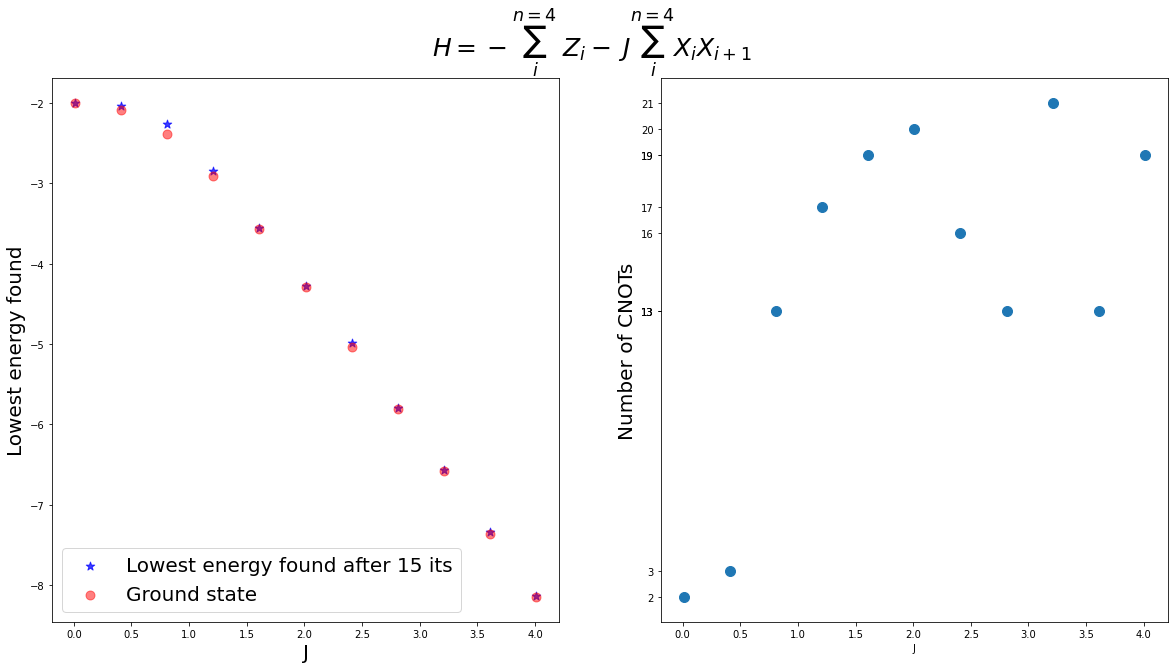

In [3]:
plt.figure(figsize=(20,10))
plt.suptitle(r'$H = -\sum_i^{n=4} \; Z_i - \;J \sum_i^{n=4} X_i X_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,2),(0,0))
ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel("Lowest energy found", size=20)
ax1.set_xlabel("J", size=20)

js = np.arange(.01,4.1,.4)
ax1.scatter(js,[k.lowest_energy_found for k in sols.values()], marker="*",alpha=.75, s=80, c="blue",label="Lowest energy found after 15 its")
ax1.scatter(js,np.loadtxt("Ising4q.csv"), alpha=.5, s=80, c="red",label="Ground state")
ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)

ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
ax2.set_xlabel("J")
ax2.set_yticks([k.count_number_cnots(k.best_circuit_found) for k in sols.values()])
ax2.set_ylabel("Number of CNOTs", size=20)
plt.savefig("ising_larger_interactions.png")

In [15]:
list(sols.items())

[('0.01', <__main__.Solver at 0x7fe99d7248d0>),
 ('0.41000000000000003', <__main__.Solver at 0x7fe8a0d6dfd0>),
 ('0.81', <__main__.Solver at 0x7fe88ef68748>),
 ('1.2100000000000002', <__main__.Solver at 0x7fe89232e748>),
 ('1.61', <__main__.Solver at 0x7fe8dccf40b8>),
 ('2.01', <__main__.Solver at 0x7fe8a1b76978>),
 ('2.41', <__main__.Solver at 0x7fe8dceb8898>),
 ('2.81', <__main__.Solver at 0x7fe8dd048c18>),
 ('3.21', <__main__.Solver at 0x7fe882544c88>),
 ('3.61', <__main__.Solver at 0x7fe8a2a99c18>),
 ('4.01', <__main__.Solver at 0x7fe895c7a8d0>)]

In [18]:
import os
import pickle
os.system("mkdir results_ising_4qb")
for k,v in sols.items():
    with open("results_ising_4qb/"+k+'.pickle', 'wb') as handle:
        pickle.dump(v, handle, protocol=pickle.HIGHEST_PROTOCOL)

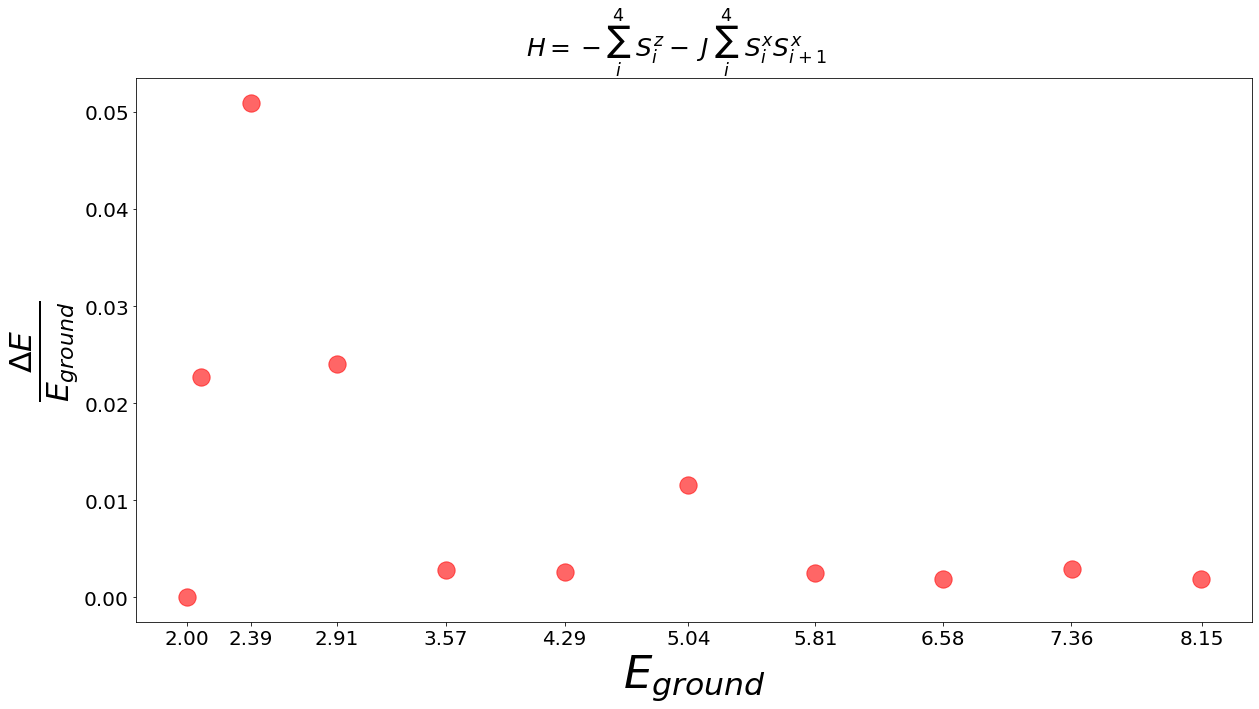

In [13]:
plt.figure(figsize=(20,10))
plt.suptitle(r'$H = -\sum_i^{4} \; S^{z}_i - \;J \; \sum_i^{4} \; S^{x}_i S^{x}_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,1),(0,0))
#ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel(r'$\frac{\Delta E}{E_{ground}}$', size=45)#(r'$|E_{lowest}- E_{ground}|$', size=30)
ax1.set_xlabel(r'$E_{ground}$', size=45)

enns = np.array(np.loadtxt("Ising4q.csv"))
js = np.arange(.01,4.1,.4)
ax1.scatter(np.abs(enns),np.abs(np.array([k.lowest_energy_found for k in sols.values()]) - enns)/np.abs(enns), marker="o",alpha=.6, s=300, c="red",label=r'$\Delta E/E_ground$')
#ax1.scatter(js,, alpha=.5, s=80, c="red",label="Ground state")
#ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)
ticks=[]
for k,i in enumerate(np.abs(enns)):
    if k!=1:
        ticks.append(np.round(i,2))
ax1.set_xticks(ticks)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
#ax2.set_xlabel("J")
#ax2.set_yticks([k.count_number_cnots(k.best_circuit_found) for k in sols.values()])
#ax2.set_ylabel("Number of CNOTs", size=20)
plt.savefig("energies_4ising.png")

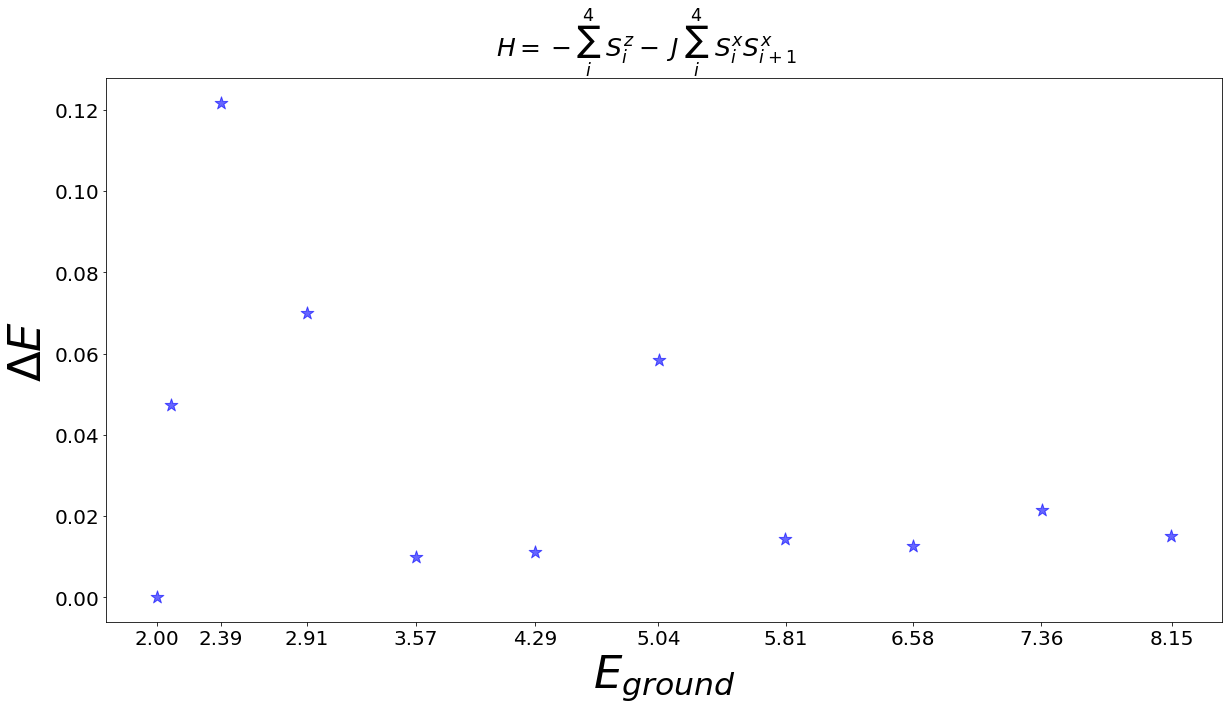

In [4]:
plt.figure(figsize=(20,10))
plt.suptitle(r'$H = -\sum_i^{4} \; S^{z}_i - \;J \; \sum_i^{4} \; S^{x}_i S^{x}_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,1),(0,0))
#ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel(r'$\Delta E$', size=45)#(r'$|E_{lowest}- E_{ground}|$', size=30)
ax1.set_xlabel(r'$E_{ground}$', size=45)

enns = np.array(np.loadtxt("Ising4q.csv"))
js = np.arange(.01,4.1,.4)
ax1.scatter(np.abs(enns),np.abs(np.array([k.lowest_energy_found for k in sols.values()]) - enns), marker="*",alpha=.6, s=180, c="blue",label=r'$\Delta E$')
#ax1.scatter(js,, alpha=.5, s=80, c="red",label="Ground state")
#ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)
ticks=[]
for k,i in enumerate(np.abs(enns)):
    if k!=1:
        ticks.append(np.round(i,2))
ax1.set_xticks(ticks)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
#ax2.set_xlabel("J")
#ax2.set_yticks([k.count_number_cnots(k.best_circuit_found) for k in sols.values()])
#ax2.set_ylabel("Number of CNOTs", size=20)
#plt.savefig("energies.png")